In [1]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')

out_path = os.path.join(proj_dir,'reports','figures','mass_loss_spinup.pdf')

In [2]:
from dask.distributed import Client
C = Client()
C

Client Scheduler: tcp://127.0.0.1:51163 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [3]:
def total_bmb(avg_paths,grd_path,vostock,time_slice):
    
    s2a = 3600*24*365.25
    rhoi = 916
    
    grd = xr.open_dataset(grd_path)
    waom = xr.open_mfdataset(avg_paths)

    mask = (grd.mask_rho == 1 )& (grd.zice < 0)
    mask[vostock[0],vostock[1]] = False

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    ismr = (waom.m.sel(ocean_time=time_slice).where(mask)*weights*s2a).sum(['xi_rho','eta_rho'])
    bmb = (waom.m.sel(ocean_time=time_slice).where(mask)*dA*rhoi*(10**-12)*s2a).sum(['xi_rho','eta_rho'])
    
    return bmb,ismr,mask

In [8]:
grd10_path = os.path.join(data_dir,'raw','waom_frc','waom10_grd.nc')
waom10_path = os.path.join(data_dir,'raw','waom10_M3','ocean_avg_00??.nc')
vostock10 = [np.arange(200,260),np.arange(400,480)]
time = slice('2012','2014')

bmb10,ismr10,mask10 = total_bmb(waom10_path,grd10_path,vostock10,time)

In [9]:
grd4_path = os.path.join(data_dir,'raw','waom_frc','waom4_grd.nc')
waom4_path = os.path.join(data_dir,'raw','waom4','ocean_avg_00??.nc')
vostock4 = [np.arange(500,650),np.arange(1000,1200)]
time = slice('2012','2014')

bmb4,ismr4,mask4 = total_bmb(waom4_path,grd4_path,vostock4,time)

In [10]:
grd2_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
waom2_path = os.path.join(data_dir,'raw','waom2_fix','ocean_his_00??.nc')
vostock2 = [np.arange(1000,1300),np.arange(2000,2400)]
time = slice('2012','2014')

bmb2,ismr2,mask2 = total_bmb(waom2_path,grd2_path,vostock2,time)

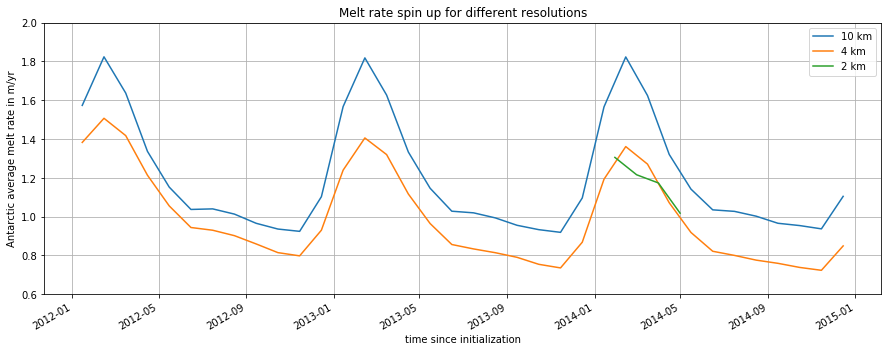

In [11]:
plt.close()
fig,ax = plt.subplots(figsize=(15,5))
ismr10.plot(label='10 km',ax=ax)
ismr4.plot(label='4 km',ax=ax)
ismr2.plot(label='2 km',ax=ax)
ax.set_ylim(0.6,2.0)
ax.set_title('Melt rate spin up for different resolutions')
ax.legend()
ax.grid()
ax.set_ylabel('Antarctic average melt rate in m/yr')
plt.savefig(out_path)
plt.show()